## **Introduction**

In this final project, I am going to use a dataset from Kaggle competition called "Dogs vs. Cats"(https://www.kaggle.com/competitions/dogs-vs-cats/overview). My goal in this project is to classify whether an image contains either a dog or a cat by using Convolutional Neural Networks.

In the dataset, we have a zipped folder called train, a zipped folder called test1, and a sampleSubmission.csv file which we will need to update our prediction in the end to check our model performance.

By inspecting the the train folder, it contains 25,000 images and it's evenly break into 2 categories, cats and dogs, and each category has 12,500 images. In our submission, we should have a predict label for each images id, and the label 1 for dog, 0 for cat.

## **Exploratory Data Analysis**
### **Load Libraries and Data**

In [30]:
import os
import numpy as np
import pandas as pd
import zipfile

import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D, Activation
from tensorflow.keras.optimizers import Adam

In [2]:
train_path = "../input/dogs-vs-cats/test1.zip"
test_path = "../input/dogs-vs-cats/train.zip"

with zipfile.ZipFile(train_path, 'r') as zipp:
    zipp.extractall("/kaggle/working/")
    
with zipfile.ZipFile(test_path, 'r') as zipp:
    zipp.extractall("/kaggle/working/")

In [3]:
dir_train = "../working/train"
dir_test = "../working/test1"

train_filenames = os.listdir(dir_train)
test_filenames = os.listdir(dir_test)

print("Number of images in train set: ", len(train_filenames))
print("Number of images in test set: ", len(test_filenames))
print("File name samples in train set: ", train_filenames[0:5])
print("File name samples in test set: ", test_filenames[0:5])

Number of images in train set:  25000
Number of images in test set:  12500
File name samples in train set:  ['cat.1933.jpg', 'cat.8802.jpg', 'dog.5394.jpg', 'dog.9646.jpg', 'dog.4084.jpg']
File name samples in test set:  ['5403.jpg', '12428.jpg', '340.jpg', '3680.jpg', '9949.jpg']


In [4]:
# Now we are going to create a dataframe for train dataset
image_paths = []
labels = []
for f in train_filenames:
    label = f.split('.')[0]
    labels.append(label)
    image_path = os.path.join(dir_train, f)
    image_paths.append(image_path)

df_train = pd.DataFrame()
df_train["path"] = image_paths
df_train["label"] = labels
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    25000 non-null  object
 1   label   25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


,path,label
0,../working/train/cat.1933.jpg,cat
1,../working/train/cat.8802.jpg,cat
2,../working/train/dog.5394.jpg,dog
3,../working/train/dog.9646.jpg,dog
4,../working/train/dog.4084.jpg,dog


In [5]:
# Now we are going to create a dataframe for test dataset, it is slightly different since it doesn't have a label column
image_paths = []
inds = []
for f in test_filenames:
    idx = f.split('.')[0]
    inds.append(idx)
    image_path = os.path.join(dir_test, f)
    image_paths.append(image_path)

df_test = pd.DataFrame()
df_test["path"] = image_paths
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    12500 non-null  object
dtypes: object(1)
memory usage: 97.8+ KB


,path
0,../working/test1/5403.jpg
1,../working/test1/12428.jpg
2,../working/test1/340.jpg
3,../working/test1/3680.jpg
4,../working/test1/9949.jpg


### **Inspect, Visualize and Clean Data**

First, by calling data info() and head() above on both training and test set, we can found that in image names, they are consist with label(either dog or cat) and the image id, and they are split by ".".

Now let us start by visualizing some images for cats and dogs in training set.

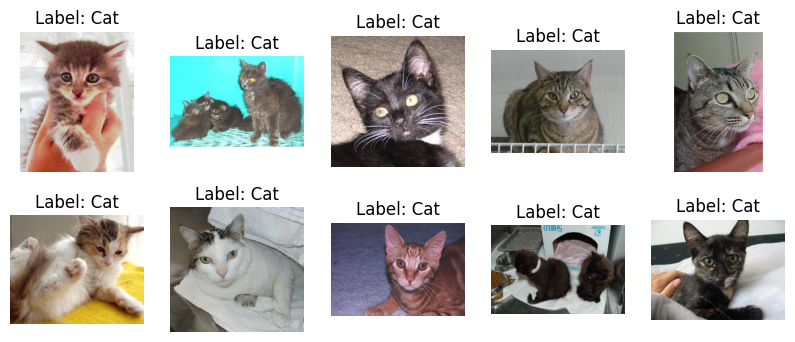

In [6]:
fig = plt.figure(figsize = (10, 4))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    image = imread("train/" + "cat." + str(100+i) + ".jpg")
    plt.imshow(image)
    ax.set_title(f'Label: {"Cat"}')
    plt.axis("off")

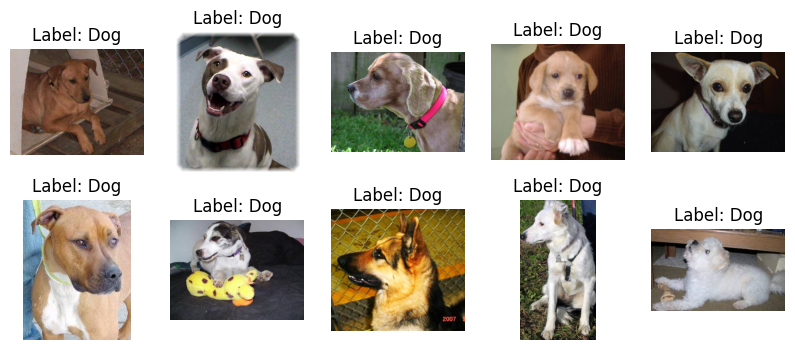

In [7]:
fig = plt.figure(figsize = (10, 4))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    image = imread("train/" + "dog." + str(100+i) + ".jpg")
    plt.imshow(image)
    ax.set_title(f'Label: {"Dog"}')
    plt.axis("off")

By viewing the above images, we can see that images are in different shape. Also, it might be more than one cat or dog in the images, for example, the second image in the cat label has three cats. Sometimes human hands or body may also shows in the images which might be harder for classification.

Now we are going to split the train/valid set, here we are going to set the stratify equals to labels in df_train. Because stratified sampling can ensure that the training and test dataset have the same proportion of class labels as the input dataset, which is 50:50 in this case.

train set size:  20000
validation set size:  5000


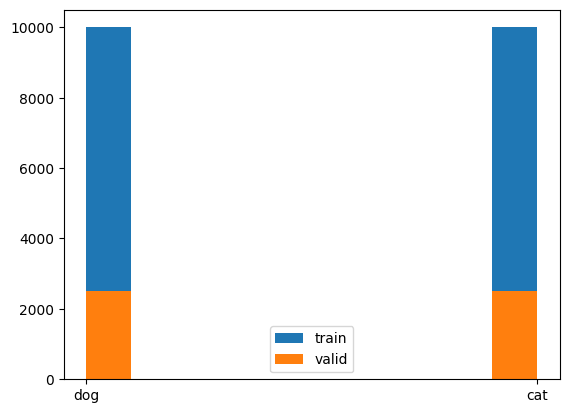

In [8]:
# Now we are going to split the train/valid dataset
train, valid = train_test_split(df_train, random_state = 42, stratify = df_train['label'], test_size = 0.2)
print("train set size: ", len(train))
print("validation set size: ", len(valid))

plt.hist(train["label"], label = "train")
plt.hist(valid["label"], label = "valid")
plt.legend()

## **Data Augmentation**

Here we are going to use ImageDataGenerator() function in order to preprocess the data. Data Augmentation is useful to improve the performance and outcomes of machine learning models by forming new and different examples to train dataset.

In [20]:
train_datagen = ImageDataGenerator(
                rescale = 1./255,
                rotation_range = 10, 
                zoom_range = 0.2,
                shear_range = 0.2,
                horizontal_flip = True,
                height_shift_range = 0.1,
                width_shift_range = 0.1)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [21]:
train_generator = train_datagen.flow_from_dataframe(
                dataframe = train, 
                x_col = "path",
                y_col = "label",
                class_mode = "binary",
                target_size = (128, 128),
                batch_size = 32,
                shuffle = False)

Found 20000 validated image filenames belonging to 2 classes.


In [22]:
valid_generator = valid_datagen.flow_from_dataframe(
                dataframe = valid, 
                x_col = "path",
                y_col = "label",
                class_mode = "binary",
                target_size = (128, 128),
                batch_size = 32,
                shuffle = False)

Found 5000 validated image filenames belonging to 2 classes.


In [36]:
test_generator = test_datagen.flow_from_dataframe(
                dataframe = df_test,
                x_col = "path",
                y_col = None,
                class_mode = None,
                targe_size = (128, 128),
                batch_size = 32,
                shuffle = False)

Found 12500 validated image filenames.


## **Create Models**

### Model Architecture:
First, I want to start with a basic model, the input layer is with 32 filters, and the activation function is relu; the model contains 3 convolution layers with increasing filters (64, 128, and 256) and all of them with activation function relu; each convolution block has a max pooling with size (2, 2); then the fully connected layer contains a flatten layer, a dense layer with 512 units; last of all, the output layer is a dense layer with 1 unit of sigmoid activation function.

In [24]:
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3), activation = "relu"))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation = "relu"))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(128, (3, 3), activation = "relu"))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(256, (3, 3), activation = "relu"))
model1.add(MaxPooling2D((2, 2)))

model1.add(Flatten())
model1.add(Dense(512, activation = "relu"))
model1.add(Dense(1, activation = "sigmoid"))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 128)     

In [25]:
# Compile the model
opt = Adam(learning_rate = 0.0001)
model1.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [27]:
# Train the model
hist1 = model1.fit(train_generator, epochs = 10, validation_data = valid_generator)

Epoch 1/10
625/625 [==============================] - 484s 774ms/step - loss: 0.5443 - accuracy: 0.7258 - val_loss: 0.4839 - val_accuracy: 0.7719
Epoch 2/10
625/625 [==============================] - 485s 775ms/step - loss: 0.4884 - accuracy: 0.7607 - val_loss: 0.4543 - val_accuracy: 0.7925
Epoch 3/10
625/625 [==============================] - 484s 775ms/step - loss: 0.4515 - accuracy: 0.7858 - val_loss: 0.4881 - val_accuracy: 0.7781
Epoch 4/10
625/625 [==============================] - 480s 768ms/step - loss: 0.4219 - accuracy: 0.8054 - val_loss: 0.3996 - val_accuracy: 0.8156
Epoch 5/10
625/625 [==============================] - 487s 779ms/step - loss: 0.3913 - accuracy: 0.8234 - val_loss: 0.3639 - val_accuracy: 0.8338
Epoch 6/10
625/625 [==============================] - 486s 778ms/step - loss: 0.3751 - accuracy: 0.8306 - val_loss: 0.3292 - val_accuracy: 0.8587
Epoch 7/10
625/625 [==============================] - 485s 777ms/step - loss: 0.3592 - accuracy: 0.8382 - val_loss: 0.3188 -

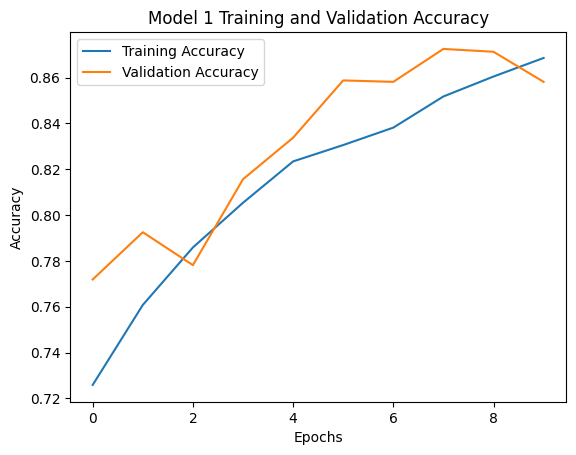

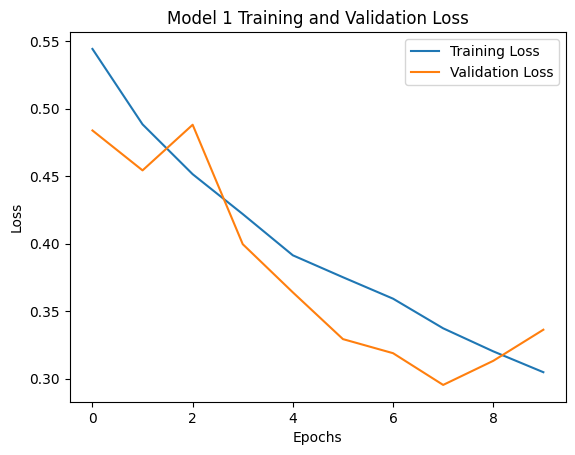

In [28]:
acc = hist1.history["accuracy"]
val_acc = hist1.history["val_accuracy"]
loss = hist1.history["loss"]
val_loss = hist1.history["val_loss"]

plt.plot(acc, label = "Training Accuracy")
plt.plot(val_acc, label = "Validation Accuracy")
plt.title("Model 1 Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.title("Model 1 Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In this model, we have training accuracy end with 0.8686, and the validation accuracy is 0.8581. I think even with a very basic model, the performance is not bad because we used data augmentation.


### Second Model

Here we are going to create a second model by adjusting some values in the first model. First, we will add a couple more convolutional blocks in the second model to see if more layers will help its performance get better.Then we are going to add batch normalization into each convolution block, a batch normalization is a method that used to make training faster and more stable through normalization of the layers' inputs by re-centering and re-scaling. Then add a dropout layer at the end to avoid overfitting.

In [31]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(64, (3, 3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(128, (3, 3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(128, (3, 3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(256, (3, 3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D((2, 2)))

model2.add(Flatten())
model2.add(Dense(512, activation = "relu"))
model2.add(Dropout(0.3))

model2.add(Dense(1, activation = "sigmoid"))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_1 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_2 (Batc  (None, 61, 61, 64)      

In [32]:
# we are going to use the same optimizer Adam
opt = Adam(learning_rate = 0.0001)
model2.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [33]:
hist2 = model2.fit(train_generator, epochs = 10, validation_data = valid_generator)

Epoch 1/10
625/625 [==============================] - 612s 976ms/step - loss: 0.5890 - accuracy: 0.6974 - val_loss: 0.5612 - val_accuracy: 0.6986
Epoch 2/10
625/625 [==============================] - 602s 963ms/step - loss: 0.4829 - accuracy: 0.7651 - val_loss: 0.4404 - val_accuracy: 0.7934
Epoch 3/10
625/625 [==============================] - 599s 958ms/step - loss: 0.4339 - accuracy: 0.7990 - val_loss: 0.3968 - val_accuracy: 0.8182
Epoch 4/10
625/625 [==============================] - 602s 964ms/step - loss: 0.4006 - accuracy: 0.8180 - val_loss: 0.3921 - val_accuracy: 0.8268
Epoch 5/10
625/625 [==============================] - 603s 964ms/step - loss: 0.3674 - accuracy: 0.8354 - val_loss: 0.3395 - val_accuracy: 0.8486
Epoch 6/10
625/625 [==============================] - 601s 962ms/step - loss: 0.3466 - accuracy: 0.8432 - val_loss: 0.3919 - val_accuracy: 0.8280
Epoch 7/10
625/625 [==============================] - 605s 968ms/step - loss: 0.3230 - accuracy: 0.8590 - val_loss: 0.3117 -

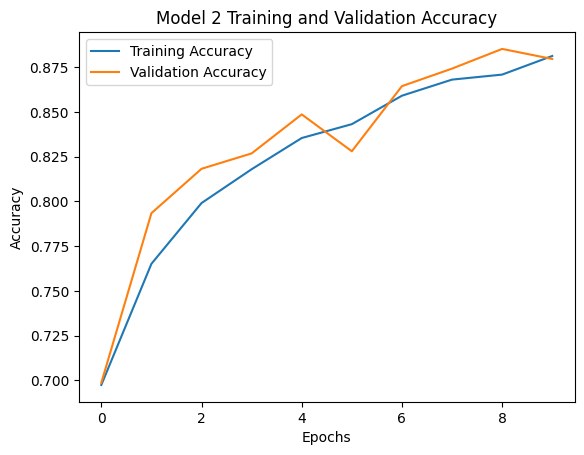

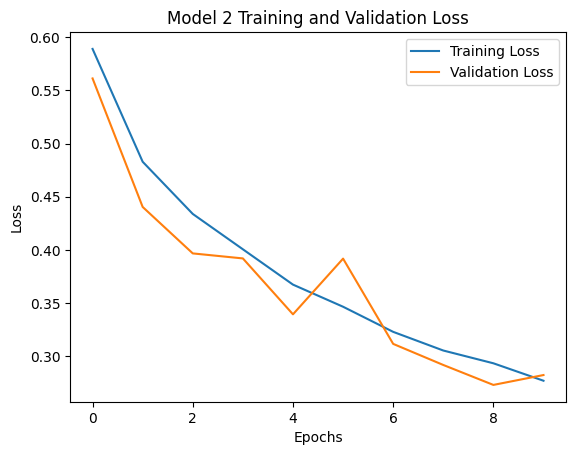

In [34]:
acc = hist2.history["accuracy"]
val_acc = hist2.history["val_accuracy"]
loss = hist2.history["loss"]
val_loss = hist2.history["val_loss"]

plt.plot(acc, label = "Training Accuracy")
plt.plot(val_acc, label = "Validation Accuracy")
plt.title("Model 2 Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.title("Model 2 Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

## **Conclusion**

In this project, we used a technique called data augmentation, and that is to artificially increase the size of a dataset by creating new data points from existing data, so it applied transformations to images, like rotating, flipping and shifting the images. This technique will improve our model performance and reduce overfitting as well.

Compare our first model and the second one, the second one has a better performance. In the second model we have made several changes, first of all we add more convolutional layers, which help us extract more features as long as the number of layers is necessary, otherwise, it may also cause overfitting. Also, we add a batch normalization layer between our convolutions, and it will regularize our model and make model more stable during training. Lastly, we add a dropout layer which randomly eliminate neurons from the model. Actually in the beginning I also added dropout layers to each convolutional layer, however, it was less effective. I think since the convolutional layers have few parameters, so they actually need less regularization to begin with, and batch normalization apply a small regularization effect.

### Prediction

In [39]:
pred = model2.predict(test_generator)
pred = np.round(pred.flatten()).astype(int)

Found 12500 validated image filenames.
782/782 [==============================] - 79s 100ms/step
12500


In [40]:
# save the predictions into submission.csv
submission = pd.DataFrame({'id': inds, 'label': pred})
submission.to_csv("submission.csv", index = False)
df = pd.read_csv("../working/submission.csv")

df.head()

,id,label
0,5403,1
1,12428,0
2,340,0
3,3680,1
4,9949,1
